In [1]:
import os
from tqdm.notebook import tqdm
import guitarpro
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np

from src.models.vae import MusicVAE
from src.parse_gp import drop_rests_from_drum_track, get_notes_and_durations
from src.save_midi import save_notes_and_durations, save_notes

In [31]:
folderpath = "tabs/"
track_name = 'guitar'

In [32]:
notes, durations = [], []
for folder in os.listdir(folderpath):
    for filename in tqdm(os.listdir(folderpath + folder + '/')):
        tab = guitarpro.parse(folderpath + folder + '/' + filename)
        try:
            tab_notes, tab_durations = get_notes_and_durations(tab, track_name, False)
            notes += tab_notes
            durations += tab_durations
        except:
            continue

  0%|          | 0/12 [00:00<?, ?it/s]

In [33]:
note_dictionary = {note: i for i, note in enumerate(set(notes))}
inv_note_dictionary = {i: note for note, i in note_dictionary.items()}
notes_to_int = [note_dictionary[note] for note in notes]
notes_to_int[:10]

[90, 88, 125, 75, 61, 220, 88, 125, 75, 61]

In [34]:
duration_dictionary = {dur: i for i, dur in enumerate(set(durations))}
inv_dur_dictionary = {i: dur for dur, i in duration_dictionary.items()}
durations_to_int = [duration_dictionary[dur] for dur in durations]
durations_to_int[:10]

[1, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [35]:
def prepare_sequences(notes, durations, length, step, n_notes, n_durations):
    batch_size = 32
    note_sequences = []
    dur_sequences = []
    for i in range(0, len(notes) - length, step):
        note_sequences.append(notes[i: i + length])
        dur_sequences.append(durations[i: i + length])
    
    note_sequences = np.array(note_sequences)
    dur_sequences = np.array(dur_sequences)
    
    length = (len(note_sequences) // batch_size) * batch_size
    indicies = np.arange(length)
    np.random.shuffle(indicies)
    
    note_targets = to_categorical(note_sequences[indicies], n_notes)    
    dur_targets = to_categorical(dur_sequences[indicies], n_durations)
    sequences = [note_sequences[indicies], dur_sequences[indicies]]
    targets = [note_targets, dur_targets]
    return sequences, targets

In [36]:
X, y = prepare_sequences(notes_to_int, durations_to_int, 128, 1, len(note_dictionary), len(duration_dictionary))
X[0].shape

(6208, 128)

In [37]:
y[0].shape

(6208, 128, 226)

In [38]:
model = MusicVAE(
    kernel_size = 32,
    encoder_filters = [32, 32, 16, 8],
    encoder_strides = [1, 2, 2, 1],
    decoder_filters = [4, 8, 16, 32],
    decoder_strides = [1, 2, 2, 1],
    n_notes = len(note_dictionary),
    n_durations = len(duration_dictionary),
    emb_size = 16,
    input_dim = X[0].shape[1],
    latent_dim = 2,
    loss_factor = 1000
)

In [39]:
model.compile(0.0001)

In [40]:
model.model.fit(
    X, y,
    shuffle=True,
    batch_size=32,
    epochs=20
)

Epoch 1/20
194/194 [==============================] - 5s 24ms/step - cce_notes: 5183.6061 - cce_durations: 1303.7925 - kl: 18.9861 - loss: 6506.3853
Epoch 2/20
194/194 [==============================] - 5s 24ms/step - cce_notes: 4314.1424 - cce_durations: 1184.5638 - kl: 20.1275 - loss: 5518.8345
Epoch 3/20
194/194 [==============================] - 5s 24ms/step - cce_notes: 4055.6839 - cce_durations: 1173.5941 - kl: 14.2519 - loss: 5243.5303
Epoch 4/20
194/194 [==============================] - 5s 25ms/step - cce_notes: 4027.6321 - cce_durations: 1156.3548 - kl: 11.4154 - loss: 5195.4023
Epoch 5/20
194/194 [==============================] - 5s 25ms/step - cce_notes: 4012.7302 - cce_durations: 1125.4329 - kl: 10.7605 - loss: 5148.9238
Epoch 6/20
194/194 [==============================] - 5s 25ms/step - cce_notes: 3998.5989 - cce_durations: 1091.2886 - kl: 10.0434 - loss: 5099.9307
Epoch 7/20
194/194 [==============================] - 5s 26ms/step - cce_notes: 3998.8140 - cce_durations:

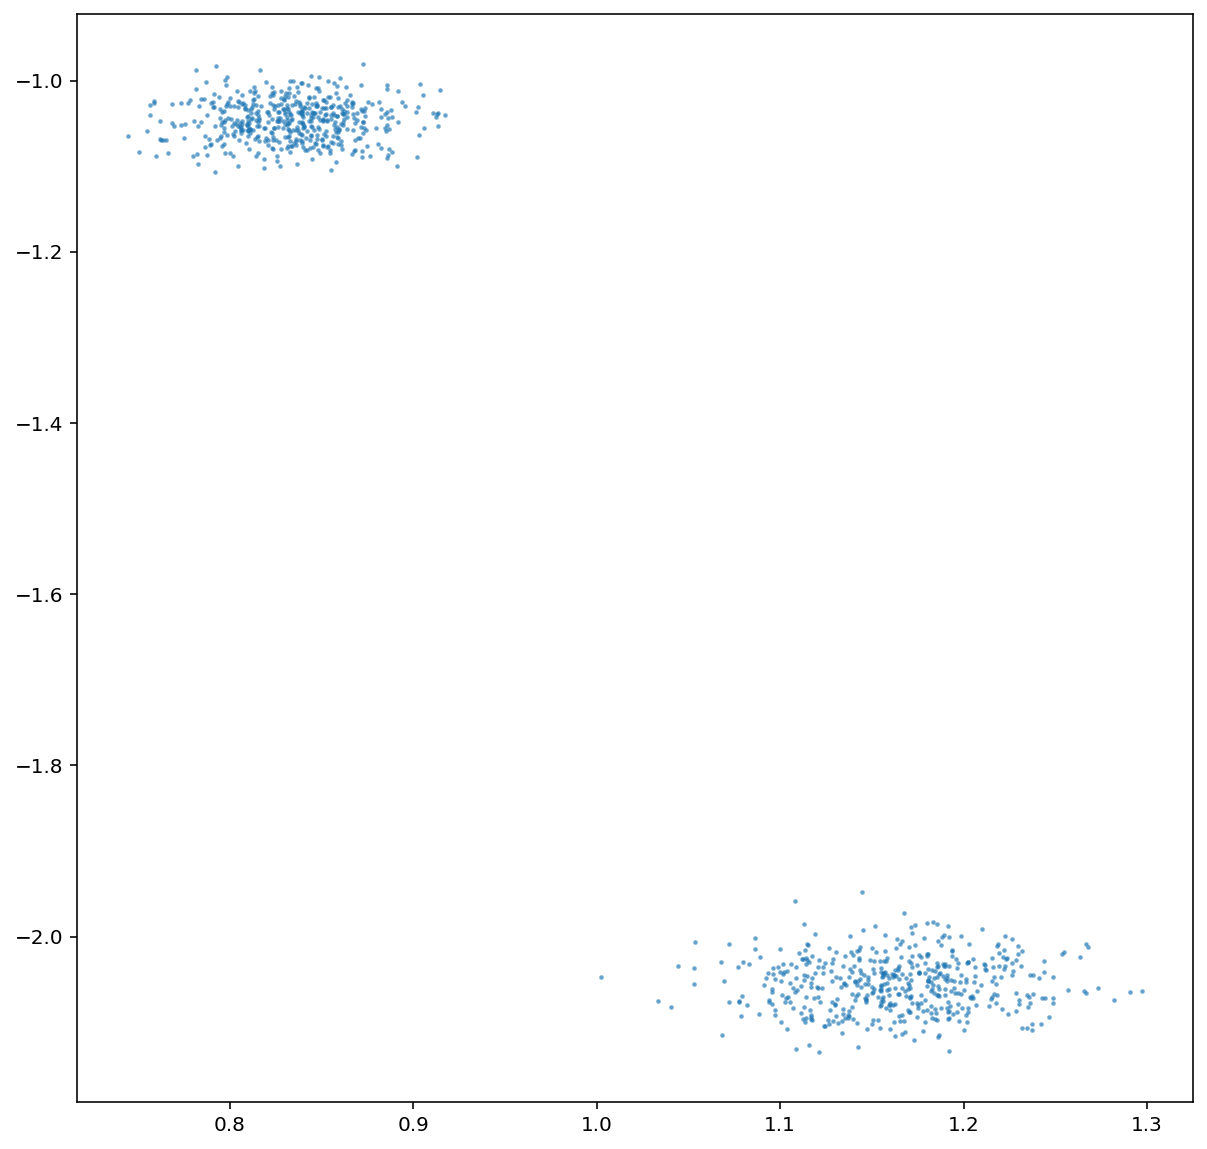

In [41]:
example_idx = np.random.choice(range(len(X)), 1000)
example_images = [X[0][example_idx], X[1][example_idx]]

_, _, z_points = model.encoder.predict(example_images)

plt.figure(figsize=(10, 10))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , alpha=0.5, s=2)
plt.show()

In [21]:
def sample(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [45]:
temperature = 0.5
generated_notes = []
generated_durations = []
predicted_notes, predicted_durations = model.decoder.predict(np.array([[-1.1, 0.85]]))
for i in range(predicted_notes.shape[1]):
    generated_notes.append(sample(predicted_notes[0][i], temperature))
    generated_durations.append(sample(predicted_durations[0][i], temperature))

In [46]:
generated = [[inv_note_dictionary[x] for x in generated_notes], [inv_dur_dictionary[x] for x in generated_durations]]

In [47]:
save_notes_and_durations(generated, 'vae_output')